# 2. Building Custom Models

When you are using AngoraPy to train goal-driven models of the brain, you will usually want these models to be _your_ custom networks. In this notebook, we show you the basics of constructing and registering your own model.

We first import necessary dependencies and then, like in the previous tutorial, build the environment and distribution.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import angorapy as apy

env = apy.make_env("CartPole-v1")
distribution = apy.policies.CategoricalPolicyDistribution(env)

If you would like to, you can also go for a different environment, for instance `LunarLander-v2`. However, training it will need a little more time and potentially a stronger network.

We now will build the model. In AngoraPy, we do not handle models itself, but instead operate on _model builders_. The reason for this is practicality in the backend of the library. Because we use truncated backpropagation through time, models need to be stateful (for an explanation of this, check the paper introducing AngoraPy). This requires models to be build with a specific sequence length. However, when collecting data, we want to do single steps, whereas we optimize on longer sequences. This requires us to constantly rebuild the model, thus demanding functions instead of objects. 

Anyways. The functions we write to build our models have some requirements.

1. Their signature mus follow the format `function(env, distribution, bs, sequence_length) -> policy, value, joint` where `env` and `distribution` are the environment and distribution the model will act upon, and `policy`, `value` and `joint` are the models (more about this below).
2. All recurrent elements need to return sequences and be stateful. In this notebook, however, we will start with a simple feedforward network. Only in the following notebook will we integrate a recurrent part.

We write a function builder for a 5-layer network, which partially shares weights between policy and value network. 

In [6]:
from tensorflow.keras.layers import TimeDistributed
from angorapy.utilities.util import env_extract_dims


def build_my_amazing_model(env, distribution, bs=1, sequence_length=None):
    inputs = apy.models.make_input_layers(env, bs)[0]
    _, n_actions = env_extract_dims(env)

    
    x = tf.keras.layers.Dense(8, activation="relu")(inputs)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x_policy = tf.keras.layers.Dense(8, activation="relu")(x)
    x_policy = tf.keras.layers.Dense(8, activation="relu")(x_policy)
    x_value = tf.keras.layers.Dense(8, activation="relu")(x)
    x_value = tf.keras.layers.Dense(8, activation="relu")(x_value)

    out_policy = distribution.build_action_head(n_actions, x_policy.shape[1:], bs)(x_policy)
    out_value = tf.keras.layers.Dense(1)(x_value)

    policy = tf.keras.Model(inputs=inputs, outputs=out_policy, name="my_policy_function")
    value = tf.keras.Model(inputs=inputs, outputs=out_value, name="my_value_function")
    joint = tf.keras.Model(inputs=inputs, outputs=[out_policy, out_value], name="my_joint_networks")

    return policy, value, joint

We can now register the function definition to the modeling module, which simply gives it a reference for e.g. loading your model at a later stage. We then build the agent with our model function and plot the model for inspection. (Note that for the plotting part we need graphviz and pyplot installed on our machine)

Detected 0 GPU devices.
Using [StateNormalizationTransformer, RewardNormalizationTransformer] for preprocessing.
[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]
[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]


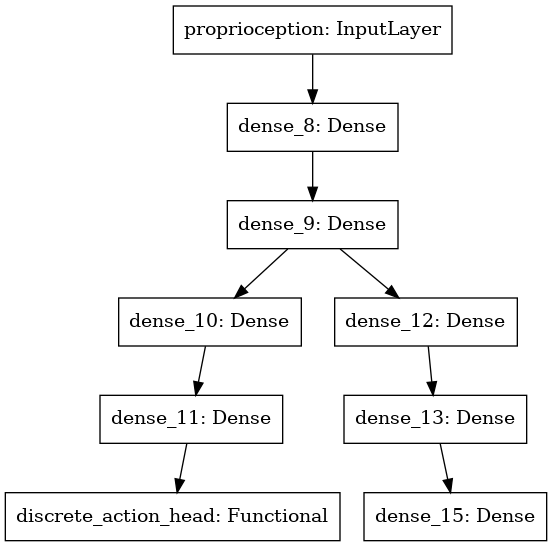

In [9]:
from tensorflow.keras.utils import plot_model

apy.register_model(build_my_amazing_model)
agent = apy.Agent(build_my_amazing_model, env, horizon=2048, workers=1, distribution=distribution)
plot_model(agent.joint)

And thats all we need to now train our model on the task, as we have previously seen in the first notebook.

In [10]:
agent.drill(n=10, epochs=10, batch_size=32)
agent.save_agent_state()



Drill started using 1 processes for 1 workers of which 1 are optimizers. Worker distribution: [1].
IDs over Workers: [[0]]
IDs over Optimizers: [[0]]
[<KerasTensor: shape=(32, 4) dtype=float32 (created by layer 'proprioception')>]
[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]
Gathering cycle 0...

Gathering experience...: 100%|█████████████| 2048/2048 [00:08<00:00, 246.19it/s]


Before Training: r:    21.91; len:    21.91; n:  93; loss: [  pi  |  v     |  ent ]; eps:     0; lr: 1.00e-03; upd:      0; f:    0.000k; y.exp: 0.000; times:  ; took s [unknown time left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:06<?, ?it/s]


Gathering cycle 1...

Gathering experience...: 100%|█████████████| 2048/2048 [00:08<00:00, 237.60it/s]


Cycle     1/10: r:    25.51; len:    25.51; n:  80; loss: [ -0.01|    0.08|  0.68]; eps:    93; lr: 1.00e-03; upd:    640; f:    2.048k; times: [10.6|0.0|6.8] [61|0|39]; took 17.39s [2.6mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 2...

Gathering experience...: 100%|█████████████| 2048/2048 [00:08<00:00, 252.84it/s]


Cycle     2/10: r:    42.08; len:    42.08; n:  48; loss: [ -0.10|    0.03|  0.64]; eps:   173; lr: 1.00e-03; upd:   1280; f:    4.096k; times: [10.4|0.0|6.0] [63|0|37]; took 16.05s [2.2mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 3...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 272.77it/s]


Cycle     3/10: r:    79.68; len:    79.68; n:  25; loss: [ -0.10|    0.03|  0.59]; eps:   221; lr: 1.00e-03; upd:   1920; f:    6.144k; times: [9.9|0.0|6.0] [62|0|38]; took 15.41s [1.9mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:06<?, ?it/s]


Gathering cycle 4...

Gathering experience...: 100%|█████████████| 2048/2048 [00:08<00:00, 233.22it/s]


Cycle     4/10: r:   165.58; len:   165.58; n:  12; loss: [  0.03|    0.04|  0.57]; eps:   246; lr: 1.00e-03; upd:   2560; f:    8.192k; times: [9.2|0.0|6.6] [58|0|42]; took 17.18s [1.7mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 5...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 273.89it/s]


Cycle     5/10: r:   245.29; len:   245.29; n:   7; loss: [  0.01|    0.05|  0.56]; eps:   258; lr: 1.00e-03; upd:   3200; f:   10.240k; times: [10.4|0.0|5.8] [64|0|36]; took 15.07s [1.4mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 6...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 274.22it/s]


Cycle     6/10: r:   443.75; len:   443.75; n:   4; loss: [  0.02|    0.04|  0.56]; eps:   265; lr: 1.00e-03; upd:   3840; f:   12.288k; times: [9.1|0.0|5.8] [61|0|39]; took 15.07s [1.1mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 7...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 275.16it/s]


Cycle     7/10: r:   408.80; len:   408.80; n:   5; loss: [ -0.02|    0.03|  0.56]; eps:   269; lr: 1.00e-03; upd:   4480; f:   14.336k; times: [9.1|0.0|6.0] [60|0|40]; took 15.25s [0.8mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 8...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 270.29it/s]


Cycle     8/10: r:   500.00; len:   500.00; n:   4; loss: [ -0.01|    0.02|  0.51]; eps:   274; lr: 1.00e-03; upd:   5120; f:   16.384k; times: [9.1|0.0|5.8] [61|0|39]; took 15.3s [0.5mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Gathering cycle 9...

Gathering experience...: 100%|█████████████| 2048/2048 [00:07<00:00, 276.82it/s]


Cycle     9/10: r:   305.33; len:   305.33; n:   6; loss: [  0.01|    0.03|  0.55]; eps:   278; lr: 1.00e-03; upd:   5760; f:   18.432k; times: [9.3|0.0|5.8] [62|0|38]; took 14.99s [0.3mins left]; mem: 1.29/12|0.0/0.0;


Optimizing...:   0%|                                    | 0/640 [00:05<?, ?it/s]


Finalizing...[<KerasTensor: shape=(32, 4) dtype=float32 (created by layer 'proprioception')>]
Drill finished after 158.53serialization.


Once again, lets evaluate the agent to check how it performs without exploration.

In [12]:
evaluation_results = agent.evaluate(1, act_confidently=True)[0]
print(f"Mean performance after training: {np.mean(evaluation_results.episode_rewards)}")

[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

Mean performance after training: 500.0


Now, since we might want to skip the training at a later stage and instead just load a previously saved agent, lets see how this works. We can load an agent from one of the states it has been saved at by calling the static `Agent.from_agent_state()` method which acts as a constructor. When training an agent using the `drill()` method, your model will be saved at every cycle, once as the _last_ agent state and once as the _best_ agent state if it is performaing better than the previous best state. Both of them are constantly overwritten, such that there is always two saved states for an agent. However, you can manually save an agent calling `agent.save_agent_state()` and additionally instruct the drill method to save at some frequency. In the following, we load the agent at the default state, `"best"`.

In [15]:
loaded_agent = apy.Agent.from_agent_state(agent.agent_id)

Detected 0 GPU devices.
Loading from iteration 9.
Detected 0 GPU devices.
Using [StateNormalizationTransformer, RewardNormalizationTransformer] for preprocessing.
[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]
[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]
Loaded optimizer.


We now have fully recovered the agent, however this agent holds the weights from the best version of itself (the original those from the last state). Lets evaluate this agent's alter ego.

In [16]:
evaluation_results = loaded_agent.evaluate(1, act_confidently=True)[0]
print(f"Mean performance after training: {np.mean(evaluation_results.episode_rewards)}")

[<KerasTensor: shape=(1, 4) dtype=float32 (created by layer 'proprioception')>]


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

Mean performance after training: 500.0


This concludes the tutorial on model building. In the following notebook we will revisit the process, but show how to do it with a recurrent network.